## QA of the risk and impact calculation for unsustainable water consumption:

Generate calculation of the water risk and impact calculations for the unsustainable water consumtion to check discrepancies.

water impacts are deffined as:

    Water impact  (m3 / year ) = (water footprint (m3/year) / production (tons)) * (production (tons) / Total Production (tons)) * Volume (tons)

    Water impact (m3 / year) = Water use per ton * distribution of crop production * tons

Equal to:
    
    Water impact  (m3 / year ) = water footprint (m3/year) * Volume (tons) / Total Production (tons)

    Water impact (m3 / year) = Water use due to the crop * percent of production you are responsible for


In [105]:
# import libraries
import geopandas as gpd
import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import numpy

import time

from rasterstats import zonal_stats

In [2]:
#define path
path = '../../datasets/raw/wf/QA/'

## Water risk:

    Water impact  (m3 / year ) = water footprint (m3/year) / Total Production (tons)

Lets have cotton as example:

In [10]:
#import geometry:
geom = gpd.read_file(path+'gadm36_IND_0.shp')
geom.head()

,GID_0,NAME_0,geometry
0,IND,India,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."


In [38]:
# explore production of cotton

!gdalinfo $path/bl_wf_mmyr_area.tif

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/wf/QA//bl_wf_mmyr_area.tif
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666649999985,83.088344470000010)
Pixel Size = (0.083333340000000,-0.083333340000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916666,  83.0883445) (179d59'30.00"W, 83d 5'18.04"N)
Lower Left  (-179.9916666, -55.9116667) (179d59'30.00"W, 55d54'42.00"S)
U

In [39]:
!gdalinfo $path/cotton/cotton_Production.tif

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/wf/QA//cotton/cotton_Production.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6
Image Structure Metadata:
  COMPRESSION=PACKBITS
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0

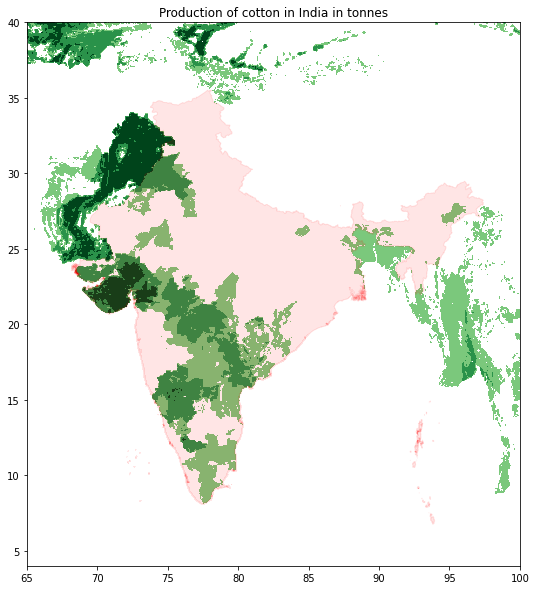

In [15]:
# Define the colors you want
cmap = ListedColormap(["#ffffff", "#7bc87c", "#2a924a", "#00441b"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 10, 100, 1000, 7000], 5)

with rio.open(path + 'cotton/cotton_Production.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((4,40))
    ax.set_xlim((65,100))
    rio.plot.show(dat, norm=norm, cmap=cmap, ax=ax, transform=src.transform)
    geom.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
    ax.set_title('Production of cotton in India in tonnes')

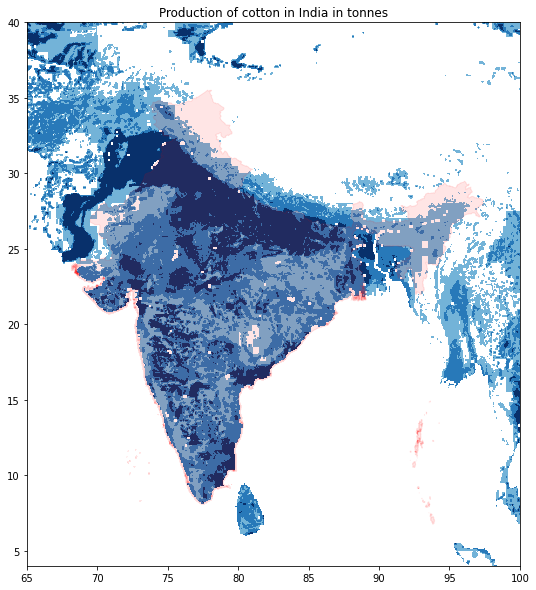

In [26]:
# Define the colors you want
cmap = ListedColormap(["#ffffff", "#73b3d8", "#2879b9", "#08306b"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0,29584100, 863202440, 10063202440,  105581714153], 5)

with rio.open(path + 'bl_wf_mmyr_area.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((4,40))
    ax.set_xlim((65,100))
    rio.plot.show(dat, norm=norm, cmap=cmap, ax=ax, transform=src.transform)
    geom.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
    ax.set_title('Production of cotton in India in tonnes')

In [31]:
## obtain total production for cotton so we can normalise the water footprint
src = rio.open(path + "cotton/cotton_Production.tif")
print('shape:',src.shape)
print('noData:',src.nodata)

array= src.read()

print(f'Total production of cotton: {array.sum()} tonnes')


shape: (2160, 4320)
noData: None
Total production of cotton: 51100000.0 tonnes


In [40]:
#clip raster by extent:
!gdal_translate -projwin -179.99166665 83.08834447 180.00836215 -55.91166665 -of GTiff $path"cotton/cotton_Production.tif" $path"cotton/cotton_Production_extent.tif"

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [45]:
#calculate risk:
#Remove production lower than 0 to avoid inconsistencies
!gdal_calc.py --calc "((A*0.001)/51100000)*(B>1)" --format GTiff --type Float32 --NoDataValue 0.0 -A $path'bl_wf_mmyr_area.tif' --A_band 1 -B $path'cotton/cotton_Production_extent.tif' --outfile $path'wr_cotton.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13

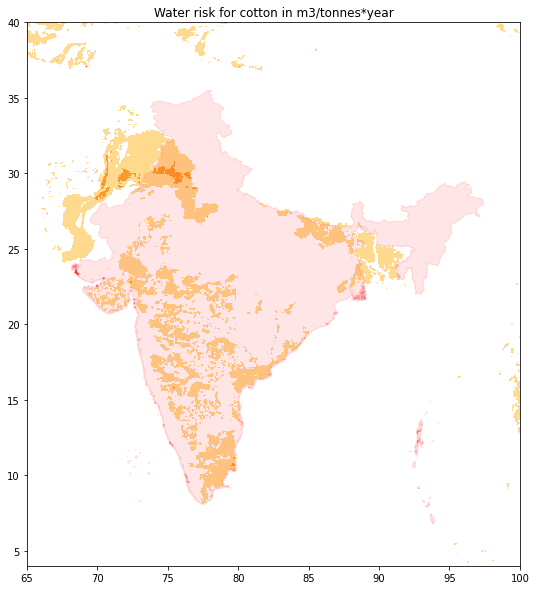

In [50]:
# Define the colors you want
cmap = ListedColormap(["#ffffff", "#fed98e", "#fe9929", "#d95f0e" ])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0,0.1, 1, 1.5,  2], 5)

with rio.open(path + 'wr_cotton.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((4,40))
    ax.set_xlim((65,100))
    rio.plot.show(dat, norm=norm, cmap=cmap, ax=ax, transform=src.transform)
    geom.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
    ax.set_title('Water risk for cotton in m3/tonnes*year')

## Compute impact:

Let's say that we have a uer that is buying 745 tonnes of cotton in india.

The volume is distributed using the 'probabilistics purchase area' approach:

    F’ = (V / TotalHarvestSrea) * (Harvest area)
    F’ = (Tons / Hectares (total)) * (Hectares)
            ^ same for the whole raster       ^ per cell


In [58]:
src = rio.open(path+'gadm36_IND_0.tif')

In [59]:
src.bounds

BoundingBox(left=-179.99166665, bottom=-55.902229309000006, right=180.00836215000004, top=83.097781811)

In [61]:
#clip raster by extent:
!gdal_translate -projwin -179.99166665 83.097781811 180.00836215000004 -55.902229309000006 -of GTiff $path"cotton/cotton_HarvestedAreaHectares.tif" $path"cotton/cotton_HarvestedAreaHectares_extent.tif"

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [78]:
#get harvest area total in india
!gdal_calc.py --calc "A*B" --format GTiff --type Float32 --NoDataValue 0.0 -A $path'gadm36_IND_0.tif' --A_band 1 -B $path'cotton/cotton_HarvestedAreaHectares_extent.tif' --outfile $path'cotton_hahectares_ind_v3.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13

In [67]:
#get production total in india
!gdal_calc.py --calc "A*B" --format GTiff --type Float32 --NoDataValue 0.0 -A $path'gadm36_IND_0.tif' --A_band 1 -B $path'cotton/cotton_Production_extent.tif' --outfile $path'cotton_production_ind.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13

In [79]:
## obtain total production for cotton so we can normalise the water footprint
src = rio.open(path + "cotton_hahectares_ind_v3.tif")
print('shape:',src.shape)
print('noData:',src.nodata)

array= src.read()
#array = src.read(1)
#array_nd = numpy.ma.masked_array(array, mask=(array == src.nodata))
#

print(f'Total harvest area of cotton: {array.sum()} hectares')

shape: (1668, 4320)
noData: 0.0
Total harvest area of cotton: 6973529.0 hectares


In [86]:
#get production total in india
!gdal_calc.py --calc "(745/6973529)*(A)" --format GTiff --type Float32 --NoDataValue 0.0 -A $path'cotton_hahectares_ind.tif' --A_band 1 --outfile $path'prob_purchase_area_IND_v3.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13

In [89]:
## check tha the volume distributed is equal to the volume injested by the user.
src = rio.open(path + "prob_purchase_area_IND_v3.tif")
print('shape:',src.shape)
print('noData:',src.nodata)

array = src.read()
#remove nans that appear outside boundary for extent
array_nonan = array[~numpy.isnan(array)]


print(f'Total harvest area of cotton: {round(array_nonan.sum())} tonnes')

shape: (1668, 4320)
noData: 0.0
Total harvest area of cotton: 745 tonnes


In [91]:
#calculate impact:
!gdal_calc.py --calc "A*B" --format GTiff --type Float32 --NoDataValue 0.0 -A $path'prob_purchase_area_IND_v3.tif' --A_band 1 -B $path'wr_cotton.tif' --outfile $path'water_impact_cotton_ind_m3yr.tif'


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13

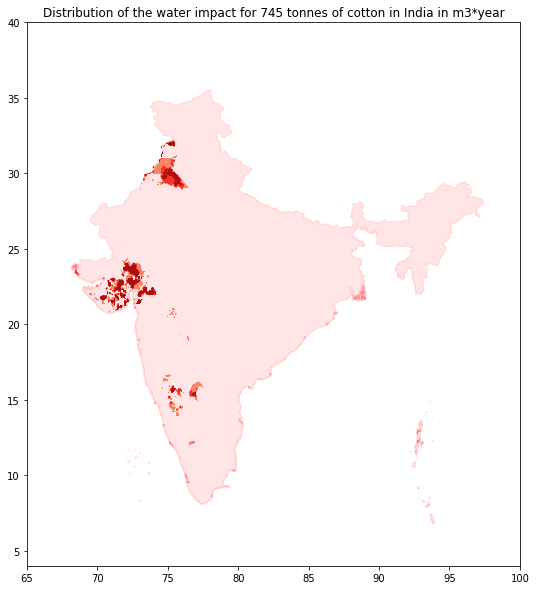

In [95]:
# Define the colors you want
cmap = ListedColormap(["#ffffff", "#fc9272", "#ef3b2c", "#a50f15" ])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0,0.025, 0.05, 0.075,  0.1], 5)

with rio.open(path + 'water_impact_cotton_ind_m3yr.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((4,40))
    ax.set_xlim((65,100))
    rio.plot.show(dat, norm=norm, cmap=cmap, ax=ax, transform=src.transform)
    geom.plot(ax=ax, color='red', alpha=.1, edgecolor='red')
    ax.set_title('Distribution of the water impact for 745 tonnes of cotton in India in m3*year')

In [93]:
## obtain totalimpact for cotton in india
src = rio.open(path + "water_impact_cotton_ind_m3yr.tif")
print('shape:',src.shape)
print('noData:',src.nodata)

array = src.read()
#remove nans that appear outside boundary for extent
array_nonan = array[~numpy.isnan(array)]


print(f'Water imapct for cotton in India: {round(array_nonan.sum())} m3/yr')

shape: (1668, 4320)
noData: 0.0
Water imapct for cotton in India: 157 m3/yr


In [97]:
!gdal_calc.py --calc "A*B" --format GTiff --type Float32 --NoDataValue 0.0 -A $path'wr_cotton.tif' --A_band 1 -B $path'gadm36_IND_0.tif' --outfile $path'wr_cotton_india.tif'

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13

In [116]:
#zonal stats in india to get the sum of all fraction harvest area
wr = path + "wr_cotton_india.tif"
start_time = time.time()
risk_zs = zonal_stats(
    geom,
    wr,
    stats="mean")
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7108137607574463 seconds ---


In [117]:
risk_zs

[{'mean': 0.16125849692493213}]

In [118]:
risk_zs[0]['mean']*745

120.13758020907444